# Step #1 Get a List of Cryptos

In [138]:
# Work in progress!
# A tutorial for this file will soon be available at www.relataly.com
# Tested with Python 3.9.13, Matplotlib 3.5.2, Seaborn 0.11.2, numpy 1.21.5, plotly 4.1.1, cryptocompare 0.7.6

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})
import cryptocompare as cc
import requests
import IPython
import yaml
import json
import matplotlib.dates as mdates # Formatting dates
from PIL import Image

# Set the API Key 
yaml_file = open('API Keys/api_config_cryptocompare.yml', 'r')  
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']
cc.cryptocompare._set_api_key_parameter(api_key)

# Request a list of coins available on cry# ptocompare
coinlist_dict = cc.get_coin_list()
crypto_list_df = pd.DataFrame.from_dict(coinlist_dict, orient='index', dtype=None, columns=None)
crypto_list_df['creation_date'] = pd.to_datetime(crypto_list_df['ContentCreatedOn'], unit='s').dt.date
crypto_list_df['creation_date_yearmonth'] = pd.to_datetime(crypto_list_df['creation_date']).dt.strftime('%Y-%m')
crypto_list_df.drop(columns=['ContentCreatedOn', 'SortOrder', 'Name', 'FullName', 'Url', 'Id', 'Sponsored', 'AssetTokenStatus'], inplace=True)
crypto_list_df

,ImageUrl,Symbol,CoinName,Description,Algorithm,ProofType,Taxonomy,Rating,creation_date,creation_date_yearmonth
BTCD,/media/19630/btcd_1.png,BTCD,BitcoinDark,Bitcoin Dark (BTCD) is a PoW and PoS hybrid al...,SHA-256,PoW/PoS,"{'Access': 'Permissionless', 'FCA': 'Exchange'...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-03-30,2015-03
CRAIG,/media/20022/craig.png,CRAIG,CraigsCoin,CraigCoin (CRAIG) is a 100% pure PoS or Proof ...,X11,PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-03-30,2015-03
XBS,/media/351060/xbs_1.png,XBS,Bitstake,To create the infrastructure necessary to impl...,X11,PoW/PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-04-10,2015-04
XPY,/media/20076/xpy_1.png,XPY,PayCoin,Paycoin is an SHA256 cryptocurrency that switc...,SHA-256,PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-04-10,2015-04
PRC,/media/20393/prc.png,PRC,ProsperCoin,ProsperCoin is a PoW cryptocurrency with a mod...,Scrypt,PoW,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-02-25,2015-02
...,...,...,...,...,...,...,...,...,...,...
IMT,/media/43881365/imt.png,IMT,IMOV,IMOV is an inclusive fitness app for people of...,N/A,N/A,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2022-11-08,2022-11
AKITA,/media/43881457/akita.png,AKITA,Akita Inu,AKITA is an experiment in decentralized commun...,N/A,N/A,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2021-05-10,2021-05
U,/media/43881459/u.png,U,Unidef,What is U protocol?U protocol is a utility tok...,N/A,N/A,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2022-10-14,2022-10
STEEMD,/media/37747003/sbd.png,STEEMD,Steem Dollars,Steem Backed Dollars or simply Steem Dollars a...,N/A,DPoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': 'E-', 'TechnologyAdoption...",2016-07-18,2016-07


In [8]:
# Display coins with Weiss Rating
json_struct = json.loads(crypto_list_df[['Rating','Symbol']].to_json(orient="records"))    
df_flat = pd.json_normalize(json_struct)
coins_sorted = df_flat[df_flat['Rating.Weiss.Rating'] != ""].sort_values(by=['Rating.Weiss.Rating', 'Rating.Weiss.TechnologyAdoptionRating', 'Rating.Weiss.MarketPerformanceRating'])
coins_sorted.reset_index().drop(columns=['index'], inplace=True)
coins_sorted.index = np.arange(1, len(coins_sorted) + 1)
coins_sorted.head(15)

,Symbol,Rating.Weiss.Rating,Rating.Weiss.TechnologyAdoptionRating,Rating.Weiss.MarketPerformanceRating
1,MATIC,B,B+,C+
2,LINK,B,B+,D+
3,BTC,B+,A-,D
4,SAND,B-,B,C
5,MANA,B-,B,C-
6,MKR,B-,B,C-
7,SUSHI,B-,B,C-
8,XLM,B-,B,D
9,ETH,B-,B,D
10,LTC,B-,B,D


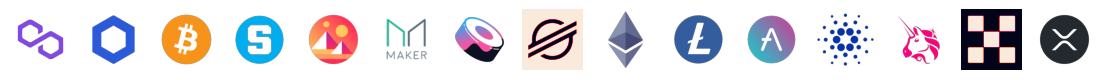

In [196]:
# Print crypto symbol icons
cryptonames = list(coins_sorted['Symbol'].head(15))
cryptonames
fig = plt.figure(figsize=(14, 14))
for i, cryptoname in enumerate(cryptonames):
    coinname_url = 'http://www.cryptocompare.com' + crypto_list_df['ImageUrl'][crypto_list_df['Symbol'] == cryptoname][0]
    im = Image.open(requests.get(coinname_url, stream=True).raw)
    fig.add_subplot(1, len(cryptonames), i+1)
    plt.imshow(im)
    plt.axis('off')

# Step #2 Load Historical Price Data

In [141]:
# Load historic BTC prices
def load_crypto_price(symbol):
    historic_dict = cc.get_historical_price_day_from(symbol)
    df = pd.DataFrame(historic_dict)
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df['date_yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
    df.drop(columns=['time', 'conversionType', 'conversionSymbol'])
    df.head()
    return df

historic_btc_price_df = load_crypto_price('BTC')
historic_eth_price_df = load_crypto_price('ETH')
historic_btc_price_df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,date,date_yearmonth
0,1314403200,6.145,6.008,6.008,1.6380,9.873,6.145,direct,,2011-08-27,2011-08
1,1314489600,6.398,6.201,6.145,0.4928,3.098,6.398,direct,,2011-08-28,2011-08
2,1314576000,6.398,6.398,6.398,0.0000,0.000,6.398,direct,,2011-08-29,2011-08
3,1314662400,6.398,6.398,6.398,0.0000,0.000,6.398,direct,,2011-08-30,2011-08
4,1314748800,6.398,6.398,6.398,0.0000,0.000,6.398,direct,,2011-08-31,2011-08


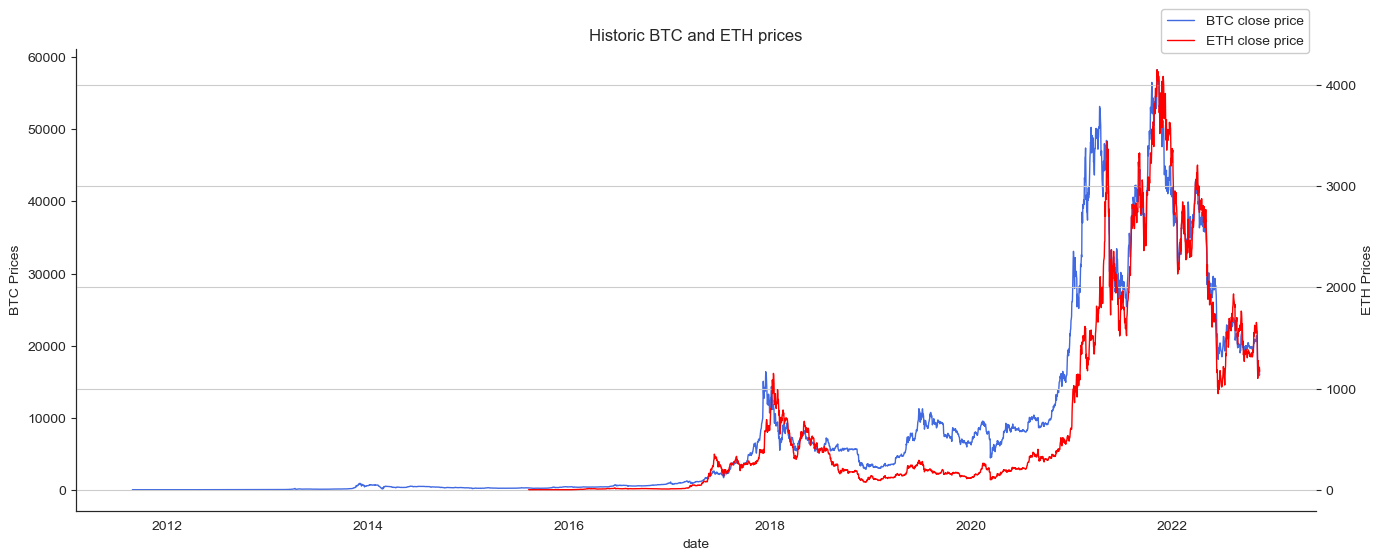

In [142]:
# Creating a Lineplot: Historic BTC and ETH prices

# function that creates a nice legend for twinx plots
def add_twinx_legend(ax1, ax2):
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=1, facecolor='white', framealpha=1, bbox_to_anchor=(1.0, 1.1))
    ax2.get_legend().remove()

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=historic_btc_price_df, x='date', y='close', color='royalblue', linewidth=1.0, label='BTC close price', ax=ax1)
ax1.set_ylabel('BTC Prices')
ax2 = ax1.twinx()
sns.lineplot(data=historic_eth_price_df, x='date', y='close', color='red', linewidth=1.0, label='ETH close price', ax=ax2)
ax2.set_ylabel('ETH Prices')
add_twinx_legend(ax1, ax2)
plt.grid()
plt.title('Historic BTC and ETH prices')
plt.show()

# Step #2 Historic Project Count

In [166]:
# Merge prices data with Bitcoin onchain data
historic_project_count_df = crypto_list_df[['Symbol','creation_date_yearmonth']].groupby(by=['creation_date_yearmonth']).count()
historic_btc_price_monthly_average_df = historic_btc_price_df[['close','date_yearmonth']].groupby(by=['date_yearmonth']).mean()
merge_df = historic_project_count_df.join(historic_btc_price_monthly_average_df)
merge_df.index.names = ['Date']
merge_df

,Symbol,close
Date,,
2014-12,2,278.359032
2015-02,15,206.127500
2015-03,82,249.057419
2015-04,242,217.890333
2015-06,27,211.074000
...,...,...
2022-07,154,21118.475806
2022-08,140,22091.041613
2022-09,29,19976.850333


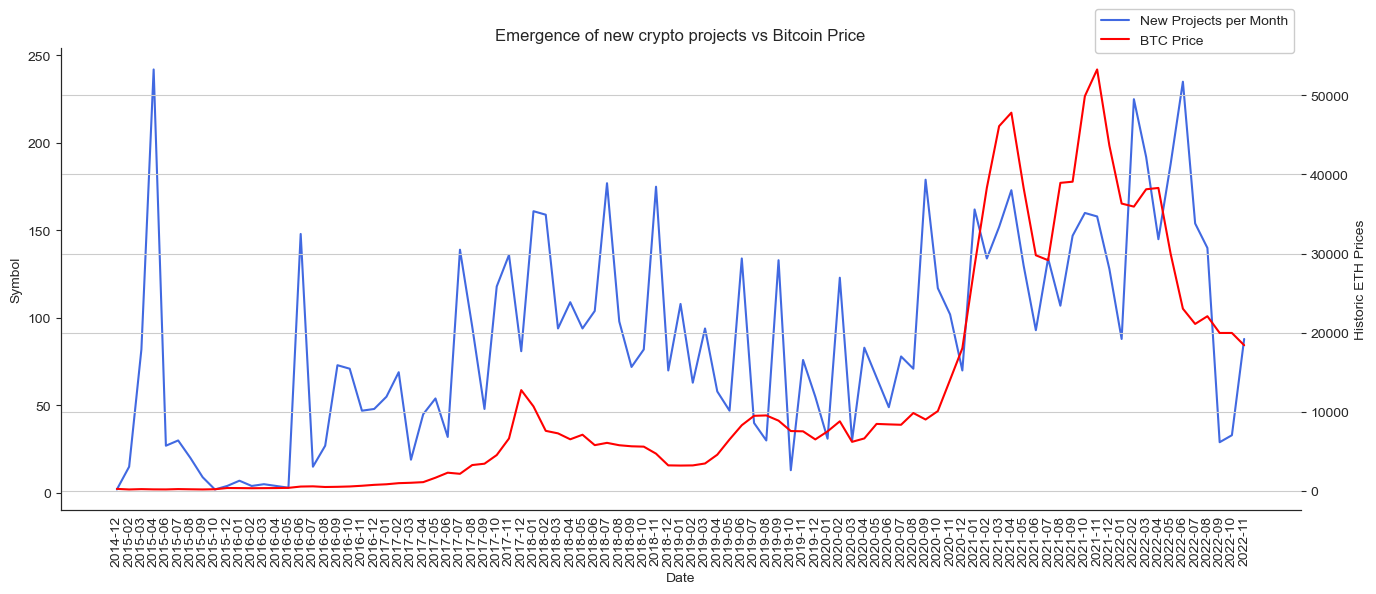

In [165]:
# Creating a Lineplot: Emergence of Crypto Projects vs Bitcoin Price
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=merge_df, x='Date', y='Symbol', color='royalblue', label='New Projects per Month', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=merge_df, x='Date', y='close', color='red', label='BTC Price',ax=ax2)
plt.ylabel('Historic ETH Prices')
plt.grid()
add_twinx_legend(ax1, ax2)
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
plt.title('Emergence of Crypto Projects vs Bitcoin Price')
plt.show()

# Step #4 Load OnChain Data

In [205]:
# Load Historic OnChain Data for Bitcoin

def get_onchain_data(crypto_symbol, data_limit):
  url = f'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym={crypto_symbol}&limit={data_limit}'

  headers = {
    'authorization': 'Apikey ' + api_key,
  }

  # API call to the cryptocompare blockchain historic data endpoint
  session = requests.Session()
  session.headers.update(headers)
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns='time', inplace=True)
  return df

data_limit = 2000
onchain_btc_df = get_onchain_data('BTC', data_limit)
onchain_eth_df = get_onchain_data('ETH', data_limit)
onchain_btc_df.head()

,id,symbol,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply,date
0,1182,BTC,247021933,264687482,472200,822114,333340,226322858,12684,8.413740,468294,4.635883e+06,5.959219e+11,552.098684,958775,1.635368e+07,2017-05-26
1,1182,BTC,247448551,265136678,449196,896081,331914,226654772,9375,8.006224,468462,4.976779e+06,5.959219e+11,514.281437,991460,1.635578e+07,2017-05-27
2,1182,BTC,247875830,265534517,397839,860215,308143,226962915,10415,9.043029,468627,4.874719e+06,5.959219e+11,525.048780,977982,1.635784e+07,2017-05-28
3,1182,BTC,248238059,265956989,422472,773589,321638,227284553,9577,7.850842,468778,4.450315e+06,5.959219e+11,575.120000,977900,1.635973e+07,2017-05-29
4,1182,BTC,248646442,266417099,460110,851547,347961,227632514,15138,10.996721,468957,5.289686e+06,5.959219e+11,483.859551,980603,1.636196e+07,2017-05-30


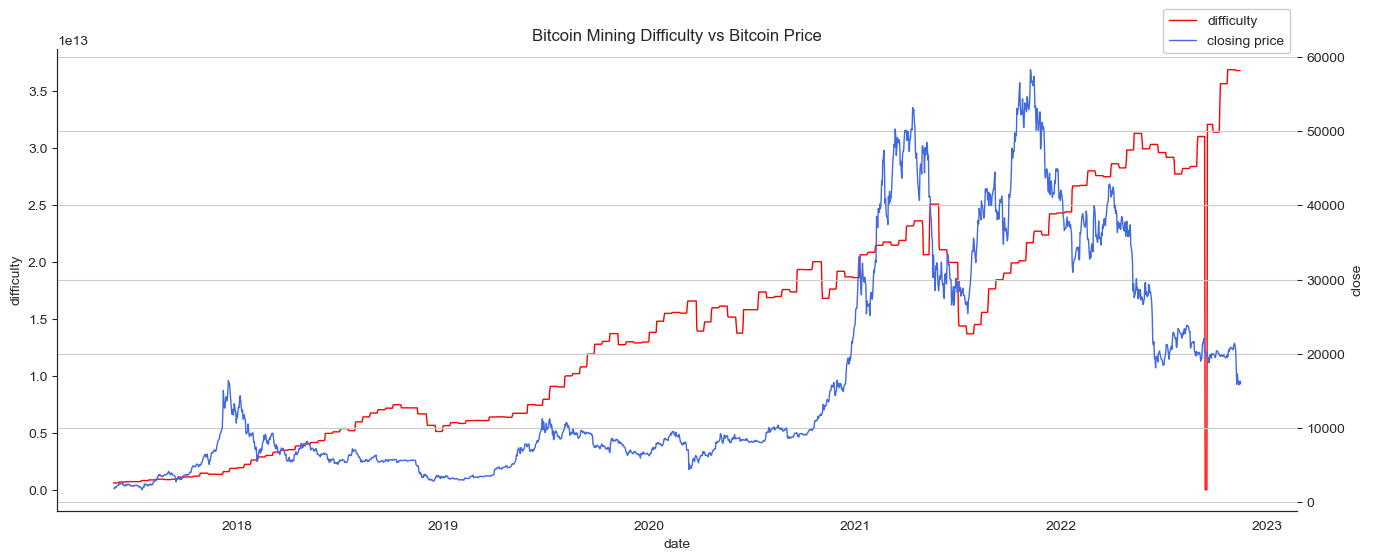

In [190]:
# Creating a Lineplot: Bitcoin Mining Difficulty vs Bitcoin Price

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_btc_df, x='date', y='difficulty', linewidth=1.0, color='red', ax=ax1, label='difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=historic_btc_price_df[-1 * data_limit:], x='date', y='close', linewidth=1.0, color='royalblue', ax=ax2, label='closing price')
add_twinx_legend(ax1, ax2)
plt.grid()
plt.title('Bitcoin Mining Difficulty vs Bitcoin Price')
plt.show()


In [222]:
# Creating a Lineplot

fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()
sns.lineplot(data=onchain_btc_df[-1*data_limit::10], x='date', y='active_addresses', linewidth=1.0, color='royalblue', ax=ax1, label='BTC active addresses')
sns.lineplot(data=onchain_btc_df[-1*data_limit::10], x='date', y='transaction_count', linewidth=1.0, color='royalblue', ax=ax2, linestyle='--', label='BTC transaction count')
sns.lineplot(data=onchain_eth_df[-1*data_limit::10], x='date', y='active_addresses', linewidth=1.0, color='red', ax=ax1, label='ETH active addresses')
sns.lineplot(data=onchain_eth_df[-1*data_limit::10], x='date', y='transaction_count', linewidth=1.0, color='red', linestyle='--', ax=ax2, label='ETH transaction count')
add_twinx_legend(ax1, ax2)
plt.show()